In [2]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ && cd /root/NVIDIA_CUDA-11.2_Samples/

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-tgcbv69o
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-tgcbv69o
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=214a63cc55017a2093697927691a7a6d2810910f71f0583c22d51a951b9e1526
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fo4obma/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
/bin/bash: line 1: cuda-install-s

In [5]:
%%cuda --name lab_1.cu
#include <cublas_v2.h>
#include <malloc.h>
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <cstdlib>
#include <curand.h>
#include <stdio.h>
#include <time.h>
#include <iostream>
#include <ctime>
#pragma comment (lib, "cublas.lib")

__global__ void matrixMultKernel(const double * A, const double * B, double * C, int nr_cols_A, int nr_cols_B) {
    int x_0 = blockIdx.x * blockDim.x + threadIdx.x;
    int y_0 = blockIdx.y * blockDim.y + threadIdx.y;
    int idx = nr_cols_B * y_0 + x_0;
    C[idx] = 0.0;
    for (int i = 0; i < nr_cols_A; i++) {
        C[idx] += A[y_0 * nr_cols_A + i] * B[i * nr_cols_B + x_0];
    }

}

void GPU_fill_rand(double* A, int nr_rows_A, int nr_cols_A) {
  curandGenerator_t prng;
  curandCreateGenerator(&prng, CURAND_RNG_PSEUDO_DEFAULT);
  curandSetPseudoRandomGeneratorSeed(prng, (unsigned long long) clock());
  curandGenerateUniformDouble(prng, A, nr_rows_A * nr_cols_A);
}

void print_matrix(double* matrix, int rows, int cols) {
  for (int i = 0; i < rows; ++i) {
    if (i > 3 && i < rows)
      continue;
    for (int j = 0; j < cols; ++j) {
      if (j > 3 && j < cols)
        continue;
      printf("%f   ", matrix[j * rows + i]);
      if (j == 2 && cols > 3)
        printf("...");
    }
    printf("\n");
    if (i == 2 && rows > 3) {
      printf("...\n");
    }
  }
  printf("\n");
}

void check_mmul(const double* A, const double* B, double* C, int nr_rows_A, int nr_cols_A, int nr_cols_B) {
  for (int i = 0; i < nr_rows_A; i++) {
    for (int j = 0; j < nr_cols_B; j++) {
      C[i * nr_cols_B + j] = 0;
      for (int t = 0; t < nr_cols_A; t++) {
        C[i * nr_cols_B + j] += A[i * nr_cols_A + t] * B[t * nr_cols_B + j];
      }
    }
  }
  printf("Check matrix =\n");
  print_matrix(C, nr_rows_A, nr_cols_B);
}


int main() {
  int size;
  std::cin >> size;
  int BLOCK_SIZE = 16;
  // Создаем массивы / выделяем память на CPU
  int nr_rows_A, nr_cols_A, nr_rows_B, nr_cols_B, nr_rows_C, nr_cols_C;
  nr_rows_A = nr_cols_A = nr_rows_B = nr_cols_B = nr_rows_C = nr_cols_C = size;

  double* h_A = (double*)malloc(nr_rows_A * nr_cols_A * sizeof(double));
  double* h_B = (double*)malloc(nr_rows_B * nr_cols_B * sizeof(double));
  double* h_C = (double*)malloc(nr_rows_C * nr_cols_C * sizeof(double));

  // Создаем массивы / выделяем память на GPU
  double* d_A, * d_B, * d_C;
  cudaError_t cuerr = cudaMalloc(&d_A, nr_rows_A * nr_cols_A * sizeof(double));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for A: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaMalloc(&d_B, nr_rows_B * nr_cols_B * sizeof(double));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for B: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaMalloc(&d_C, nr_rows_C * nr_cols_C * sizeof(double));
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot allocate device array for B: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }

  // Создание обработчиков событий
  cudaEvent_t start, stop;
  cuerr = cudaEventCreate(&start);
  if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot create CUDA start event: %s\n",
      cudaGetErrorString(cuerr));
    return 0;
  }
  cuerr = cudaEventCreate(&stop);
    if (cuerr != cudaSuccess) {
    fprintf(stderr, "Cannot create CUDA stop event: %s\n",
      cudaGetErrorString(cuerr));
    return 0;
  }

  cudaEventRecord(start, 0);

  // Заполняем массивы A и B на GPU рандомными значениями
  GPU_fill_rand(d_A, nr_rows_A, nr_cols_A);
  GPU_fill_rand(d_B, nr_rows_B, nr_cols_B);

  // Умножение матриц GPU
  //gpu_blas_mmul(d_A, d_B, d_C, nr_rows_A, nr_cols_A, nr_cols_B);
  dim3 threadsPerBlock = dim3 (BLOCK_SIZE, BLOCK_SIZE);
  dim3 blocksPerGrid = dim3 (nr_cols_B / BLOCK_SIZE, nr_rows_A / BLOCK_SIZE);

  // Запуск ядра
  matrixMultKernel<<< blocksPerGrid, threadsPerBlock >>>(d_A, d_B, d_C, nr_cols_A, nr_cols_B);
  cuerr = cudaGetLastError();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot launch CUDA kernel: %s\n", cudaGetErrorString(cuerr));
    return 0;
  }
  // Синхронизация устройств
  cuerr = cudaDeviceSynchronize();
  if (cuerr != cudaSuccess)
  {
    fprintf(stderr, "Cannot synchronize CUDA kernel: %s\n",
    cudaGetErrorString(cuerr));
    return 0;
  }
  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  float mmul_time = 0.0f;
  cudaEventElapsedTime(&mmul_time, start, stop);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);
  std::cout << nr_cols_A << std::endl;
  printf("...............\n");

  // Копирование матриц на CPU
  cudaMemcpy(h_A, d_A, nr_rows_A * nr_cols_A * sizeof(double), cudaMemcpyDeviceToHost);
  cudaMemcpy(h_B, d_B, nr_rows_B * nr_cols_B * sizeof(double), cudaMemcpyDeviceToHost);

  clock_t time_cpu;
  time_cpu = clock();
  //Умножение матриц CPU
  check_mmul(h_A, h_B, h_C, nr_rows_A, nr_cols_A, nr_cols_B);
  time_cpu = clock() - time_cpu;

  // Вывод исходных матриц
  std::cout << "A = " << std::endl;
  print_matrix(h_A, nr_rows_A, nr_cols_A);
  std::cout << "B = " << std::endl;
  print_matrix(h_B, nr_rows_B, nr_cols_B);

  // Копирование результата умножения на CPU
  cudaMemcpy(h_C, d_C, nr_rows_C * nr_cols_C * sizeof(double), cudaMemcpyDeviceToHost);
  std::cout << "C = " << std::endl;
  print_matrix(h_C, nr_rows_C, nr_cols_C);

  mmul_time = mmul_time / 1000;
  printf("..............\n");
  printf("Mmul time GPU: %.4f \n", mmul_time);
  printf("Mmul time CPU: %.4f \n", (double) time_cpu / CLOCKS_PER_SEC);

  //Освобождение памяти GPU
  cudaFree(d_A);
  cudaFree(d_B);
  cudaFree(d_C);
  // Освобождение памяти CPU
  free(h_A);
  free(h_B);
  free(h_C);
  return 0;
}

'File written in /content/src/lab_1.cu'

In [6]:
!nvcc -o /content/src/lab_1 /content/src/lab_1.cu -lcurand -lcublas

In [12]:
!/content/src/lab_1

2000
2000
...............
Check matrix =
497.607992   493.254097   486.217441   ...496.133198   
507.711434   501.499074   496.671634   ...513.741813   
501.526346   494.660881   490.824574   ...502.166576   
...
514.560529   513.084836   497.018529   ...523.969779   

A = 
0.766784   0.897322   0.391286   ...0.910785   
0.227991   0.354228   0.683641   ...0.346546   
0.393942   0.403887   0.008077   ...0.036739   
...
0.681095   0.247599   0.066391   ...0.973323   

B = 
0.051543   0.732224   0.512258   ...0.992670   
0.003170   0.019418   0.560055   ...0.524301   
0.662905   0.946074   0.575261   ...0.154337   
...
0.735129   0.498396   0.247193   ...0.118532   

C = 
497.607992   493.254097   486.217441   ...496.133198   
507.711434   501.499074   496.671634   ...513.741813   
501.526346   494.660881   490.824574   ...502.166576   
...
514.560529   513.084836   497.018529   ...523.969779   

..............
Mmul time GPU: 0.2016 
Mmul time CPU: 129.0634 


Таблица с результатами эксаперимета:

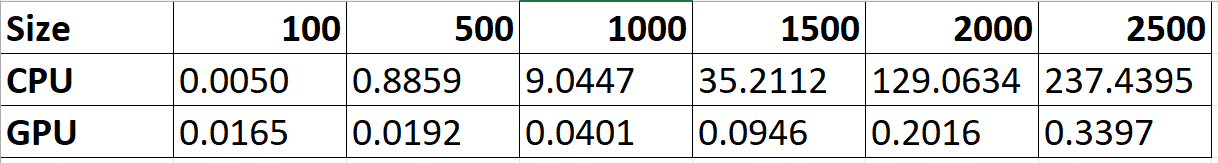

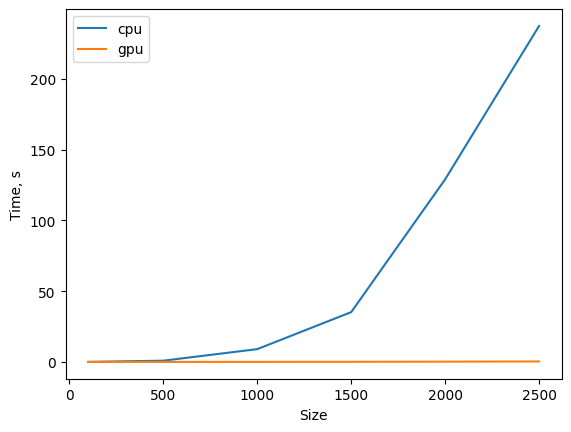

In [15]:
import matplotlib.pyplot as plt
x = [100, 500, 1000, 1500, 2000, 2500]
cpu = [0.0050, 0.8859, 9.0447, 35.2112, 129.0634, 237.4395]
gpu = [0.0165, 0.0192, 0.0401, 0.0946, 0.2016, 0.3397]
plt.xlabel("Size")
plt.ylabel("Time, s")
plt.plot(x, cpu, label='cpu')
plt.plot(x, gpu, label='gpu')
plt.legend()
plt.show()

Для вычисления ускорения параллельной программы относительно
последовательной необходимо найти отношение времени работы
последовательного алгоритма к времени исполнения параллельного
алгоритма.

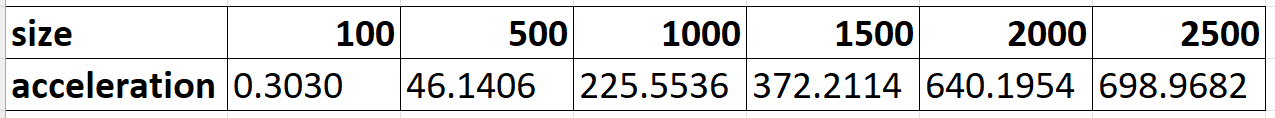

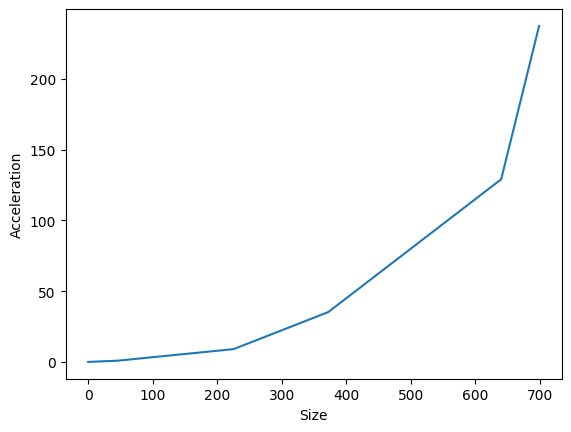

[0.30303030303030304, 46.14062500000001, 225.5536159600998, 372.2114164904862, 640.1954365079365, 698.9682072416839]


In [17]:
a = [cpu[i] / gpu[i] for i in range(len(cpu))]
plt.xlabel("Size")
plt.ylabel("Acceleration")
plt.plot(a, cpu)
plt.show()
print(a)

Как видно из результатов, наилучшее ускорение (почти в 700 раз) алгоритм с использованием технологии CUDA показал на размерностях матриц 2500 элементов. Причем, для размерности 100 распараллеливание вычислений не дает ускорения по сравнению с последовательным алгоритмом. Из этого можно сделать вывод, что для маленьких размеров матриц применение технологии CUDA не является эффективным. Выигрыш в времени при использовании видеокарты объясняется в том числе наличием у нее большого числа ядер, способных производить вычисления.